# Análise para o departamento de Produção e Manutenção
Objetivo: Identificar e segmentar defeitos em imagens
## Carga dos dados

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models, applications, callbacks
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import os
import utilities

2022-06-06 20:54:02.253400: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-06 20:54:02.253437: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
all_images_df = pd.read_csv("./defect_and_no_defect.csv")
all_images_df

ImageID  label
0      0002cc93b.jpg      1
1      0007a71bf.jpg      1
2      000a4bcdd.jpg      1
3      000f6bf48.jpg      1
4      0014fce06.jpg      1
...              ...    ...
12992  0482ee1d6.jpg      0
12993  04802a6c2.jpg      0
12994  03ae2bc91.jpg      0
12995  04238d7e3.jpg      0
12996  023353d24.jpg      0

[12997 rows x 2 columns]

ImageId: Nome do aquivo <br>
label: Indicativo de defeito (1: possui defeito; 0: não possui defeito)

In [3]:
defect_class_mask_df = pd.read_csv("./train.csv")
defect_class_mask_df

ImageId  ClassId  \
0     d2291de5c.jpg        1   
1     78416c3d0.jpg        3   
2     2283f2183.jpg        3   
3     f0dc068a8.jpg        3   
4     00d639396.jpg        3   
...             ...      ...   
5743  c12842f5e.jpg        3   
5744  2222a03b3.jpg        3   
5745  b43ea2c01.jpg        1   
5746  1bc37a6f4.jpg        3   
5747  f4413e172.jpg        3   

                                          EncodedPixels  
0     147963 3 148213 9 148461 18 148711 24 148965 2...  
1     54365 3 54621 7 54877 10 55133 12 55388 14 556...  
2     201217 43 201473 128 201729 213 201985 5086 20...  
3     159207 26 159412 77 159617 128 159822 179 1600...  
4     229356 17 229595 34 229850 36 230105 37 230360...  
...                                                 ...  
5743  88 23 342 29 596 34 850 39 1105 44 1361 46 161...  
5744  63332 4 63587 11 63841 20 64096 27 64351 35 64...  
5745  185024 7 185279 11 185535 12 185790 13 186045 ...  
5746  303867 1 304122 3 304376 6 304613 3 304630 9 3...  
5747  254911 3 255165 8 255419 12 255672 18 255926 2...  

[5748 rows x 3 columns]

ImageId: Nome do aquivo <br>
ClassId: Tipos de defeito <br>
EncodedPixels: Máscara da imagem com pixels codificados por Run Length Encoding (RLE)

## Análise de dados

In [4]:
all_images_df.label.value_counts()

1    7095
0    5902
Name: label, dtype: int64

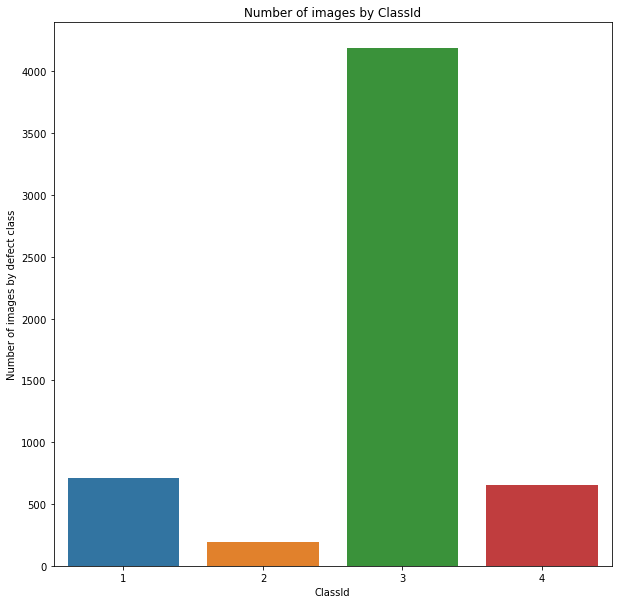

In [5]:
plt.figure(figsize=(10, 10))
sns.countplot(x=defect_class_mask_df.ClassId)
plt.ylabel("Number of images by defect class")
plt.xlabel("ClassId")
plt.title("Number of images by ClassId");

Percebe=se que o dado é bastante desbalanceado

In [6]:
defect_class_mask_df['mask'] = 1
defect_type = defect_class_mask_df.groupby(by="ImageId")['mask'].count()
defect_type

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
                ..
ffcf72ecf.jpg    1
fff02e9c5.jpg    1
fffe98443.jpg    1
ffff4eaa8.jpg    1
ffffd67df.jpg    1
Name: mask, Length: 5474, dtype: int64

Checando se em uma imagem existe mais de uma ocorrencia de defeito

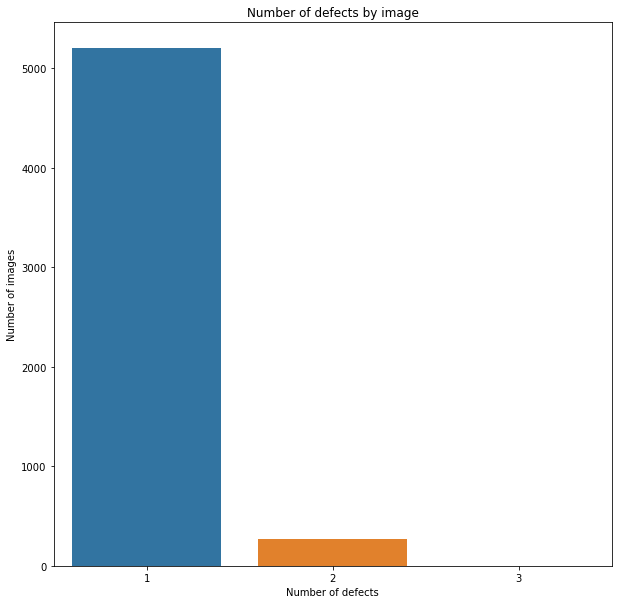

In [7]:
plt.figure(figsize=(10, 10))
sns.barplot(x=defect_type.value_counts().index, y=defect_type.value_counts())
plt.ylabel("Number of images")
plt.xlabel("Number of defects")
plt.title("Number of defects by image");

### Visualização das imagens

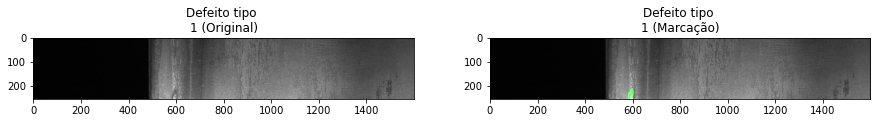

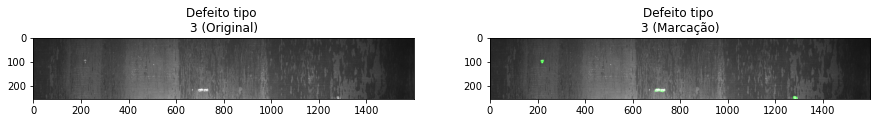

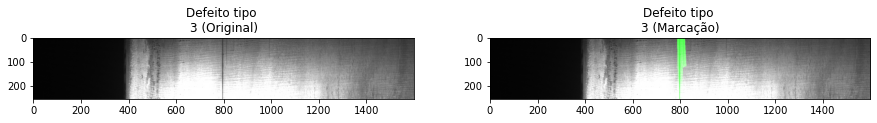

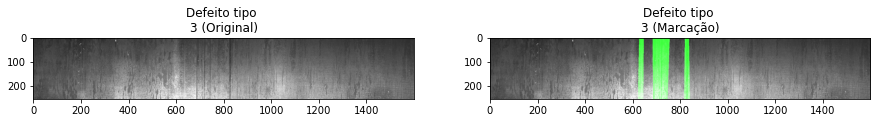

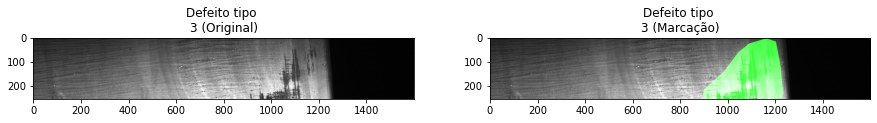

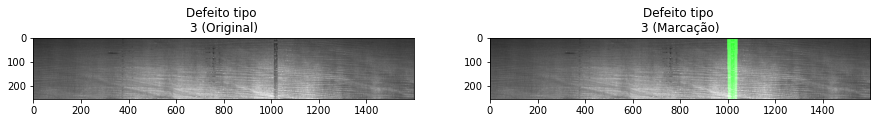

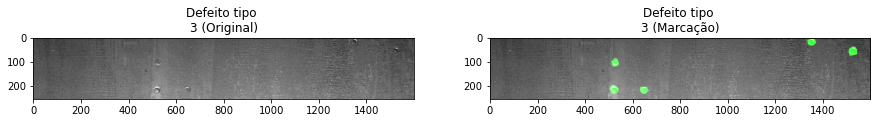

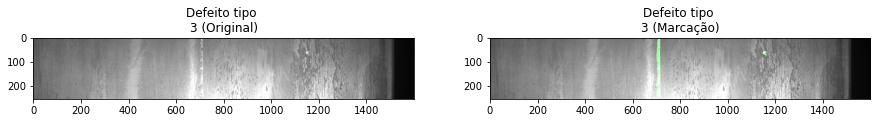

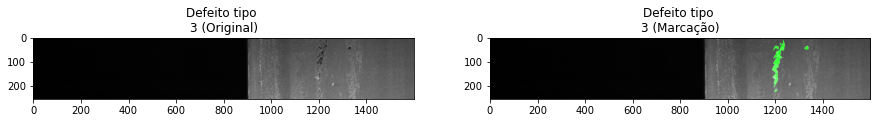

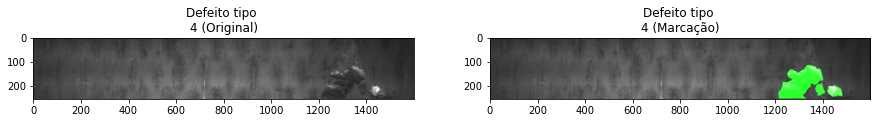

In [8]:
train_dir = "./train_images/"
for i in range(10):
    plt.figure(figsize=(15, 15))
    
    img = cv2.imread(train_dir + defect_class_mask_df.ImageId[i])
    plt.subplot(1, 2, 1)
    plt.title(f"Defeito tipo \n{defect_class_mask_df.ClassId[i]} (Original)")
    plt.imshow(img)
    
    mask = utilities.rle2mask(defect_class_mask_df.EncodedPixels[i], img.shape[0], img.shape[1])
    img[mask == 1, 1] = 255
    plt.subplot(1, 2, 2)
    plt.title(f"Defeito tipo \n{defect_class_mask_df.ClassId[i]} (Marcação)")
    plt.imshow(img)

## Previsão se existe defeito ou não com ResNet50
### Separação do dado em treino, teste e validação

In [9]:
train, test = train_test_split(all_images_df, train_size=0.85)
train.shape, test.shape

((11047, 2), (1950, 2))

In [10]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)
train_generator = datagen.flow_from_dataframe(dataframe=train, directory=train_dir, x_col="ImageID", 
                                             y_col="label", subset="training", batch_size=16,
                                             shuffle=True, class_mode="other", target_size=(256,256))

Found 9390 validated image filenames.


/home/daniel/miniconda3/envs/dissertacao/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="ImageID". These filename(s) will be ignored.
  warnings.warn(


In [11]:
valid_generator = datagen.flow_from_dataframe(dataframe=train, directory=train_dir, x_col="ImageID", 
                                              y_col="label", subset="validation", batch_size=16,
                                             shuffle=True, class_mode="other", target_size=(256,256))

Found 1656 validated image filenames.


In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test, directory=train_dir, x_col="ImageID", 
                                             y_col=None, batch_size=16, class_mode=None, shuffle=False,
                                             target_size=(256,256))

Found 1950 validated image filenames.


### Criação do modelo

In [13]:
basemodel = applications.ResNet50(weights="imagenet", include_top=False, input_tensor=layers.Input(shape=(256, 256, 3)))

2022-06-06 20:54:17.040801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-06 20:54:17.040895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-06 20:54:17.040952: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-06-06 20:54:17.040992: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-06-06 20:54:17.041027: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [14]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [15]:
for layer in basemodel.layers[:-10]:
    layer.trainable = False

In [16]:
headmodel = basemodel.output
headmodel = layers.AveragePooling2D(pool_size=(4, 4))(headmodel)
headmodel = layers.Flatten()(headmodel)
headmodel = layers.Dense(256, activation="relu")(headmodel)
headmodel = layers.Dropout(0.2)(headmodel)
headmodel = layers.Dense(1, activation="sigmoid")(headmodel)

model = models.Model(inputs=basemodel.input, outputs=headmodel)
optimizer = optimizers.RMSprop(learning_rate=0.0001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics="acc")

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [17]:
callback_list = [
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=1e-3, mode='min'),
    callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True, mode="min"),
    callbacks.ModelCheckpoint(filepath="weights.hdf5", save_best_only=True)
]

### Treinamento

In [18]:
history = model.fit(train_generator, epochs=40, validation_data=valid_generator, callbacks=callback_list)

2022-06-06 20:54:18.216614: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
587/587 [==============================] - 398s 674ms/step - loss: 0.5887 - acc: 0.6845 - val_loss: 0.6444 - val_acc: 0.6818


/home/daniel/miniconda3/envs/dissertacao/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/40
587/587 [==============================] - 385s 656ms/step - loss: 0.5178 - acc: 0.7353 - val_loss: 0.7053 - val_acc: 0.5543
Epoch 3/40
587/587 [==============================] - 381s 649ms/step - loss: 0.4823 - acc: 0.7543 - val_loss: 0.4717 - val_acc: 0.8001
Epoch 4/40
587/587 [==============================] - 379s 646ms/step - loss: 0.4621 - acc: 0.7699 - val_loss: 0.6991 - val_acc: 0.7373
Epoch 5/40
587/587 [==============================] - 375s 639ms/step - loss: 0.4426 - acc: 0.7789 - val_loss: 0.9383 - val_acc: 0.6214
Epoch 6/40
587/587 [==============================] - 372s 634ms/step - loss: 0.4298 - acc: 0.7853 - val_loss: 0.7673 - val_acc: 0.7192
Epoch 7/40
587/587 [==============================] - 369s 628ms/step - loss: 0.4220 - acc: 0.7929 - val_loss: 11.0289 - val_acc: 0.4620
Epoch 8/40
587/587 [==============================] - 394s 671ms/step - loss: 0.4207 - acc: 0.7928 - val_loss: 0.4707 - val_acc: 0.7711
Epoch 9/40
587/587 [===========================

### Avaliação da ResNet50

In [19]:
test_predict = model.predict(test_generator, verbose=1) 

122/122 [==============================] - 60s 491ms/step


In [20]:
test_predict[1]

array([0.98665076], dtype=float32)

Considerando apenas probabilidades muito confiáveis. Pois ainda passará por outra rede neural

In [21]:
predict = [0 if x < 0.1 else 1 for x in test_predict]
original = test.label

In [22]:
accuracy_score(original, predict)

0.8117948717948718

<AxesSubplot:>

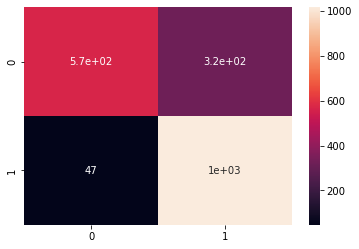

In [23]:
cm = confusion_matrix(original, predict)
sns.heatmap(cm, annot=True)

In [24]:
print(classification_report(original, predict))

              precision    recall  f1-score   support

           0       0.92      0.64      0.76       888
           1       0.76      0.96      0.85      1062

    accuracy                           0.81      1950
   macro avg       0.84      0.80      0.80      1950
weighted avg       0.83      0.81      0.81      1950



### Salvando o modelo

In [25]:
model.save("./resnet_model")

2022-06-07 01:24:38.080080: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./resnet_model/assets


/home/daniel/miniconda3/envs/dissertacao/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Segmentação de imagens em peças defeituosas com a UNet
### Separação do dado em treino e teste

In [26]:
train, val = train_test_split(defect_class_mask_df, train_size=0.85)
train.shape, val.shape

((4885, 4), (863, 4))

In [27]:
train_ids = list(train.ImageId)
train_class = list(train.ClassId)
train_rle = list(train.EncodedPixels)

val_ids = list(val.ImageId)
val_class = list(val.ClassId)
val_rle = list(val.EncodedPixels)

In [28]:
training_generator = utilities.DataGenerator(train_ids, train_class, train_rle, train_dir)
validation_generator = utilities.DataGenerator(val_ids, val_class, val_rle, train_dir)

### Criação do modelo

In [29]:
def resblock(x, f):
    x_copy = x
    
    x = layers.Conv2D(f, kernel_size=(1, 1), strides=(1, 1), kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(f, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    
    x_copy = layers.Conv2D(f, kernel_size=(1, 1), strides=(1, 1), kernel_initializer="he_normal")(x_copy)
    x_copy = layers.BatchNormalization()(x_copy)
    
    x = layers.Add()([x, x_copy])
    x = layers.Activation("relu")(x)
    
    return x


def upsample_concat(x, skip):
    x = layers.UpSampling2D((2, 2))(x)
    merge = layers.Concatenate()([x, skip])
    
    return merge

In [30]:
input_shape = (256, 256, 1)
x_input = layers.Input(input_shape)

# Estagio 1
conv1_in = layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(x_input)
conv1_in = layers.BatchNormalization()(conv1_in)
conv1_in = layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(conv1_in)
conv1_in = layers.BatchNormalization()(conv1_in)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv1_in)

# Estagio 2
conv2_in = resblock(pool_1, 32)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv2_in)

# Estagio 3
conv3_in = resblock(pool_2, 64)
pool_3 = layers.MaxPool2D(pool_size=(2, 2))(conv3_in)

# Estagio 4
conv4_in = resblock(pool_3, 128)
pool_4 = layers.MaxPool2D(pool_size=(2, 2))(conv4_in)

# Estagio 5
conv5_in = resblock(pool_4, 256)

# Up 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Up 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Up 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Up 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final
output = layers.Conv2D(4, kernel_size=(1, 1), activation="sigmoid", padding="same")(up_4)

model_seg = models.Model(x_input, output)

In [31]:
optimizer = optimizers.Adam(learning_rate=0.01, epsilon=0.1)
model_seg.compile(optimizer=optimizer, loss=utilities.focal_tversky, metrics=utilities.tversky)

model_seg.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
____________________________________________________________________________________________

In [32]:
callback_list = [
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-3, mode='min'),
    callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True, mode="min"),
    callbacks.ModelCheckpoint(filepath="weights_unet.hdf5", save_best_only=True)
]

### Treino

In [33]:
history = model_seg.fit(training_generator, epochs=40, validation_data=validation_generator, callbacks=callback_list)

Epoch 1/40
305/305 [==============================] - 613s 2s/step - loss: 0.9516 - tversky: 0.0639 - val_loss: 0.9452 - val_tversky: 0.0723
Epoch 2/40
305/305 [==============================] - 609s 2s/step - loss: 0.9307 - tversky: 0.0912 - val_loss: 0.9207 - val_tversky: 0.1041
Epoch 3/40
305/305 [==============================] - 610s 2s/step - loss: 0.8833 - tversky: 0.1519 - val_loss: 0.8488 - val_tversky: 0.1956
Epoch 4/40
305/305 [==============================] - 610s 2s/step - loss: 0.7499 - tversky: 0.3170 - val_loss: 0.7167 - val_tversky: 0.3568
Epoch 5/40
305/305 [==============================] - 608s 2s/step - loss: 0.6713 - tversky: 0.4104 - val_loss: 0.6708 - val_tversky: 0.4110
Epoch 6/40
305/305 [==============================] - 609s 2s/step - loss: 0.6438 - tversky: 0.4423 - val_loss: 0.6514 - val_tversky: 0.4339
Epoch 7/40
305/305 [==============================] - 610s 2s/step - loss: 0.6226 - tversky: 0.4664 - val_loss: 0.6300 - val_tversky: 0.4580
Epoch 8/40
30

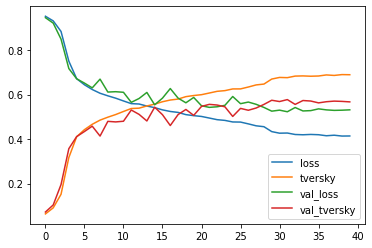

In [34]:
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['tversky'], label="tversky")
plt.plot(history.history['val_loss'], label="val_loss")
plt.plot(history.history['val_tversky'], label="val_tversky")
plt.legend()

### Salvando o modelo

In [43]:
model_seg.save("./unet_model")

INFO:tensorflow:Assets written to: ./unet_model2/assets


/home/daniel/miniconda3/envs/dissertacao/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Avaliação das modelagens

### Carregando modelos

In [44]:
resnet_model = models.load_model("./resnet_model")
unet_model = models.load_model("./unet_model", custom_objects={"focal_tversky": utilities.focal_tversky, "tversky": utilities.tversky})

### Carga do dado de teste

In [45]:
test_df = pd.read_csv("./test.csv")
test_df

ImageId  ClassId                                      EncodedPixels
0    0ca915b9f.jpg        3  188383 3 188637 5 188892 6 189148 5 189403 6 1...
1    7773445b7.jpg        3  75789 33 76045 97 76300 135 76556 143 76811 15...
2    5e0744d4b.jpg        3  120323 91 120579 182 120835 181 121091 181 121...
3    6ccde604d.jpg        3  295905 32 296098 95 296290 159 296483 222 2967...
4    16aabaf79.jpg        1  352959 24 353211 28 353465 31 353719 33 353973...
..             ...      ...                                                ...
633  a4334d7da.jpg        4  11829 7 12073 20 12317 32 12566 40 12821 41 13...
634  418e47222.jpg        3  46340 43 46596 127 46852 211 47108 253 47364 2...
635  817a545aa.jpg        3  206529 64 206657 4518 211201 179 211457 128 21...
636  caad490a5.jpg        3  59631 10 59867 30 60103 50 60339 69 60585 79 6...
637  a5e9195b6.jpg        3  321 51 424 43 577 51 641 82 833 51 897 82 1089...

[638 rows x 3 columns]

### Predição

In [46]:
image_id, defect_type, mask = utilities.prediction(test_df, resnet_model, unet_model)

In [47]:
df_pred = pd.DataFrame({"ImageId": image_id, "EncodedPixels": mask, "ClassId": defect_type})
df_pred

ImageId                                      EncodedPixels  ClassId
0    0ca915b9f.jpg  186556 2 186583 1 186585 3 186812 2 186839 1 1...        3
1    7773445b7.jpg  5691 1 5693 5 5947 1 5949 5 6203 1 6205 5 6459...        3
2    5e0744d4b.jpg  117613 4 117618 1 117649 1 117869 4 117874 1 1...        3
3    6ccde604d.jpg  365582 4 365838 4 366094 4 366350 4 366606 4 3...        3
4    16aabaf79.jpg  197856 3 198112 3 198368 3 198624 3 198880 3 1...        3
..             ...                                                ...      ...
633  a4334d7da.jpg  13619 10 13875 10 14131 10 14387 10 14643 10 1...        3
634  418e47222.jpg  21726 5 21982 5 22238 5 22494 5 22750 5 23006 ...        3
635  817a545aa.jpg  128918 4 129174 4 129430 4 129686 4 129942 4 1...        3
636  caad490a5.jpg  28127 4 28383 4 28639 4 28895 4 29151 4 29407 ...        3
637  a5e9195b6.jpg  65 71 321 71 577 71 833 71 1089 71 1345 71 160...        3

[638 rows x 3 columns]

### Comparação das imagens original e segmentada pelo modelo

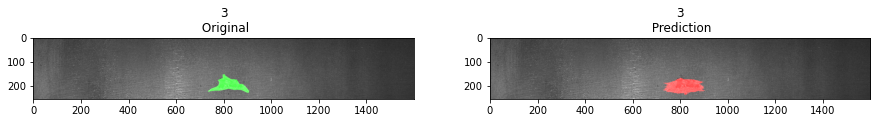

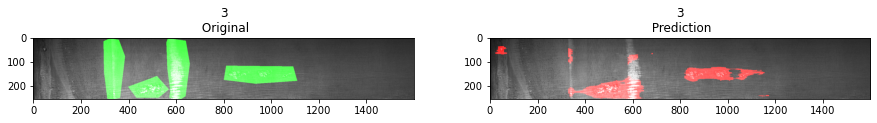

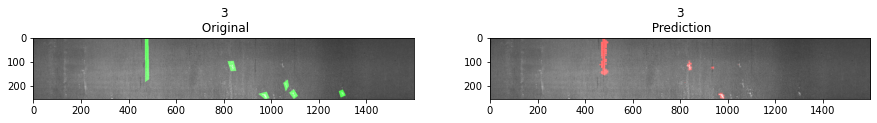

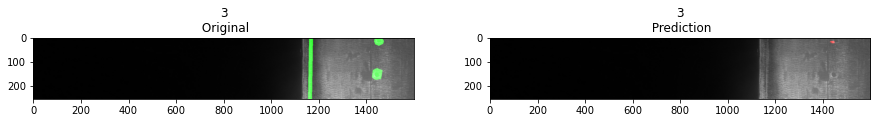

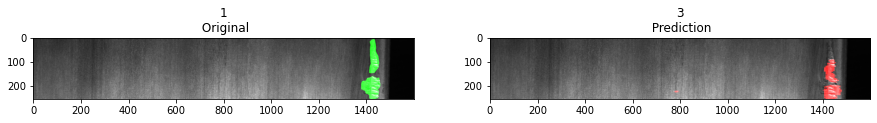

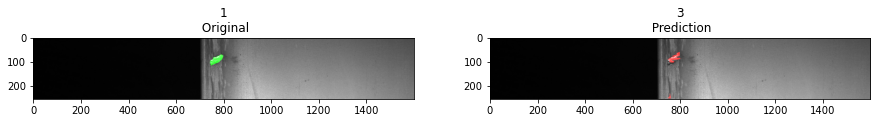

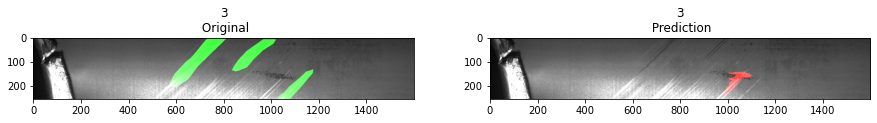

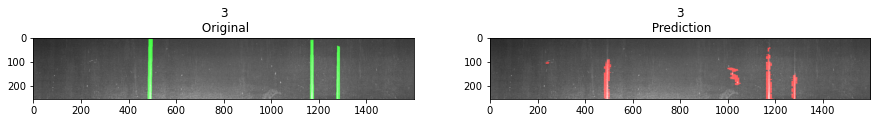

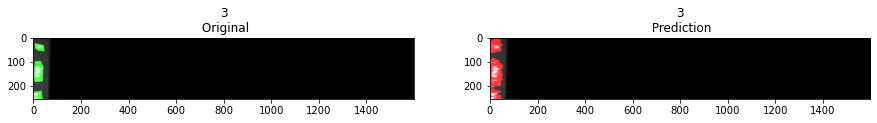

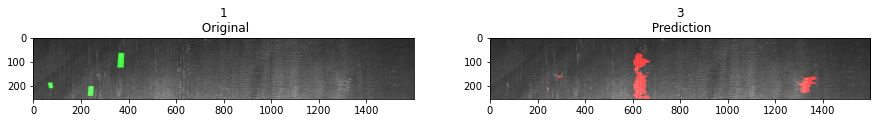

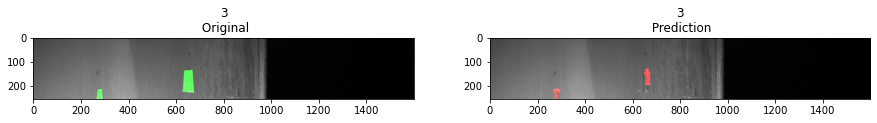

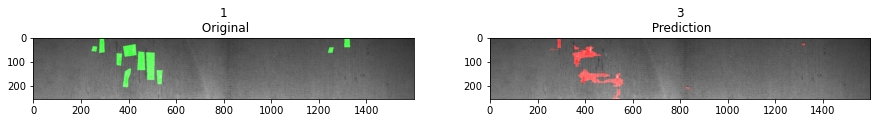

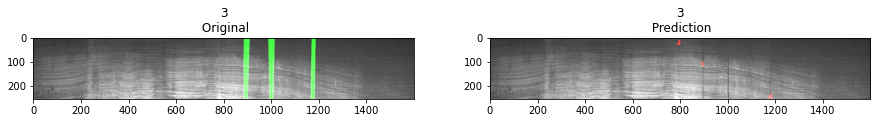

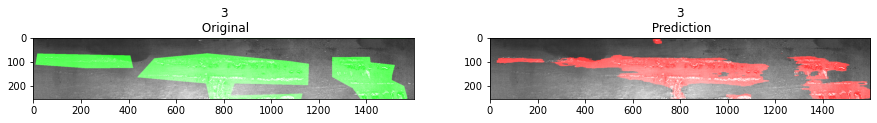

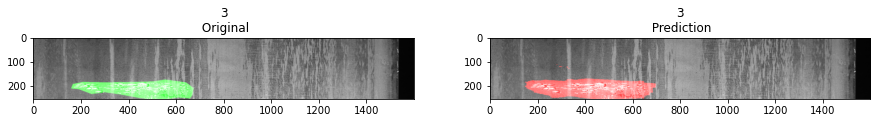

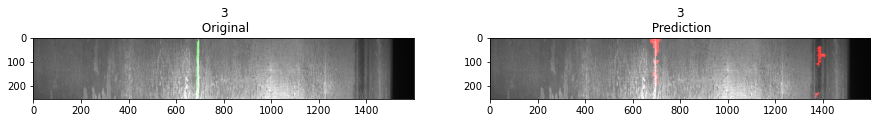

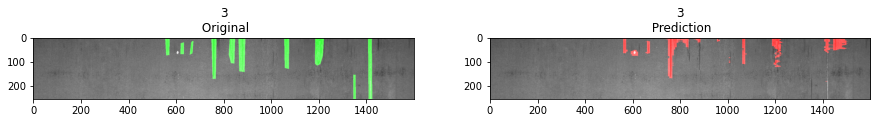

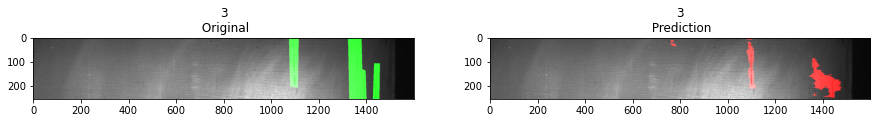

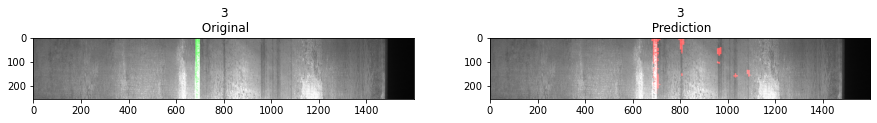

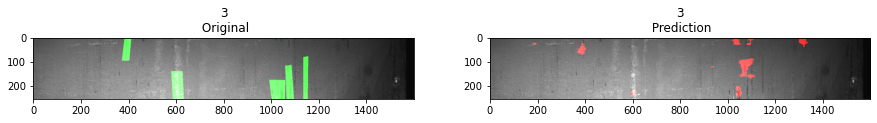

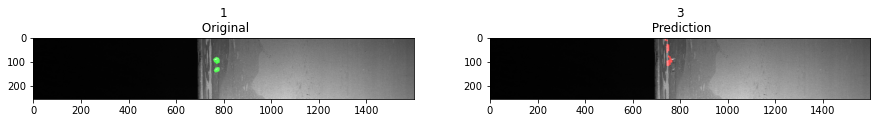

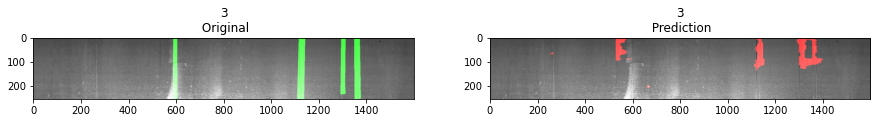

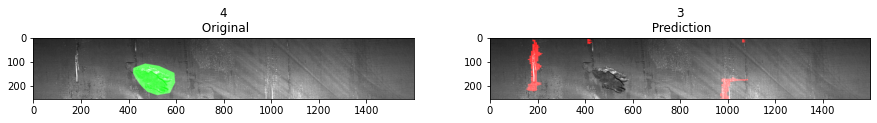

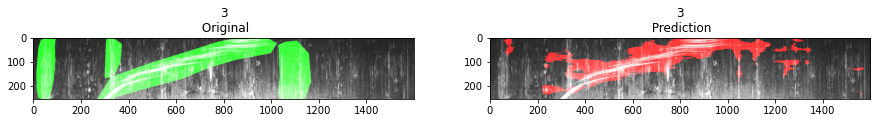

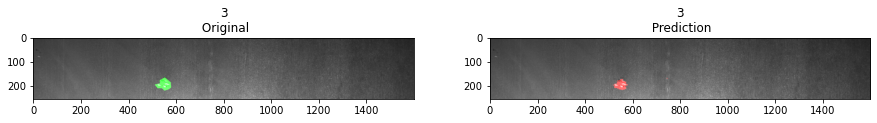

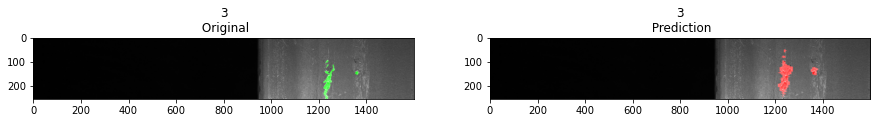

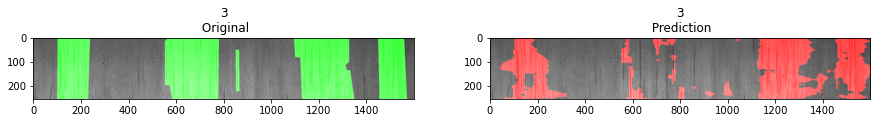

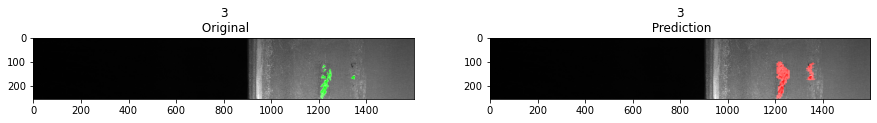

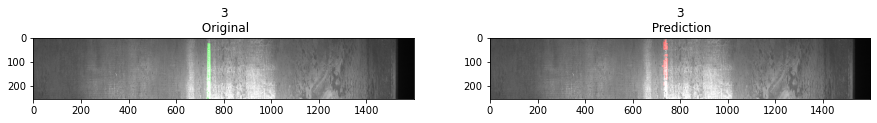

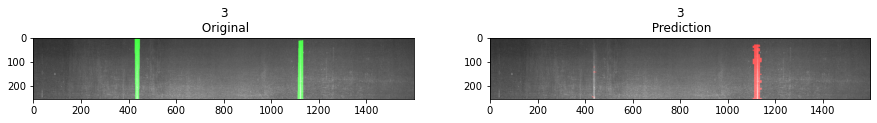

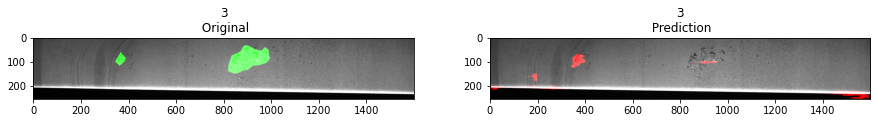

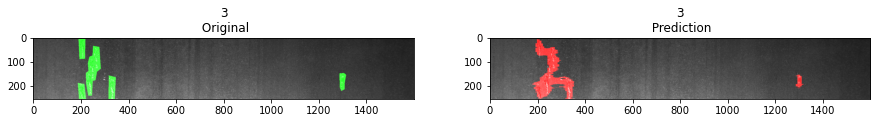

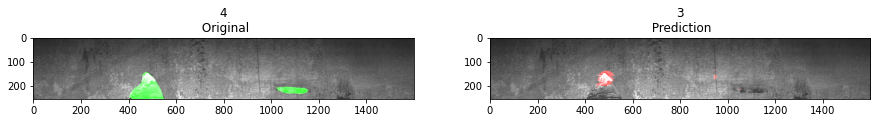

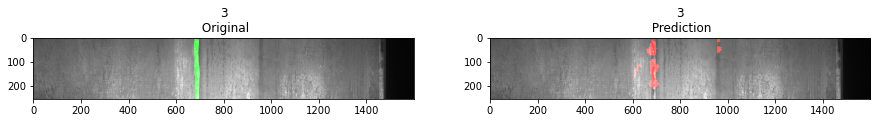

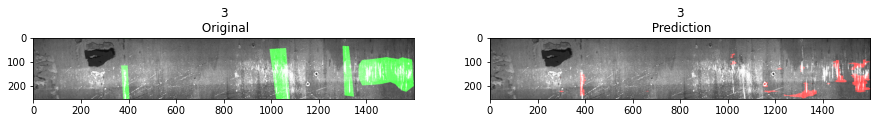

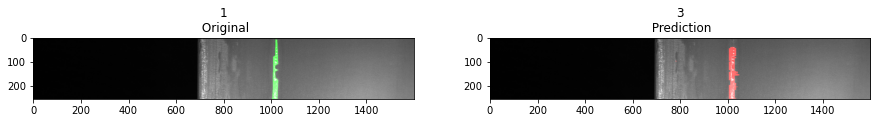

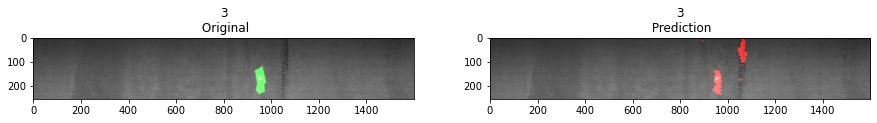

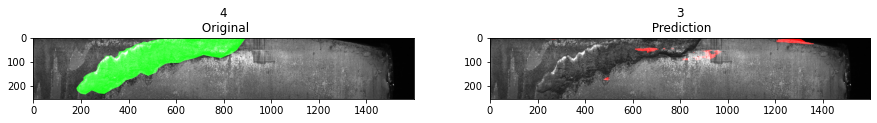

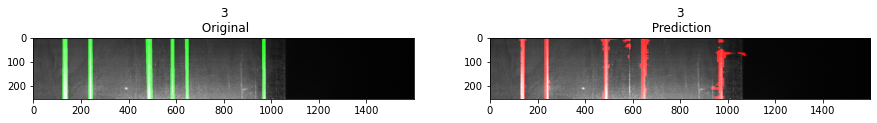

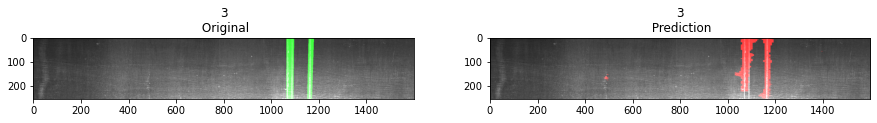

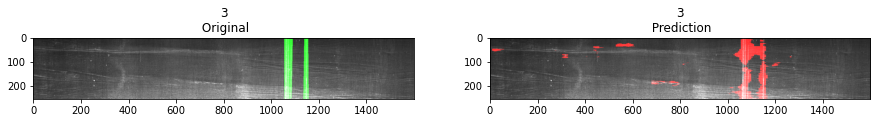

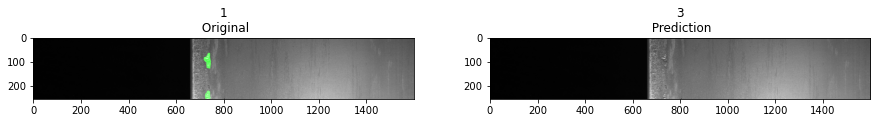

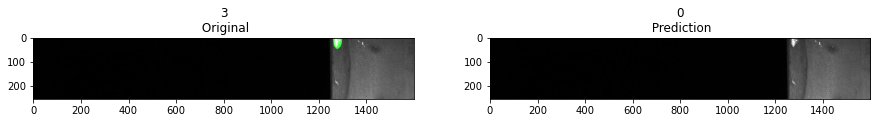

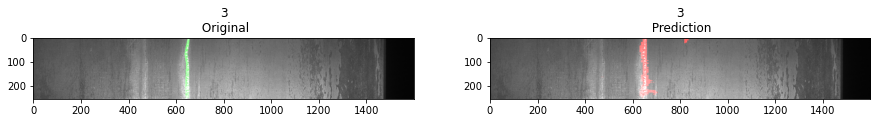

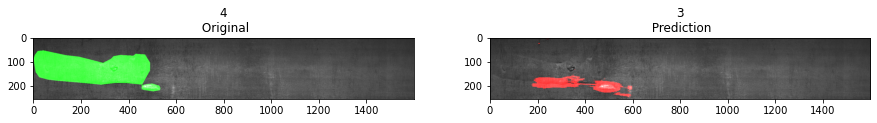

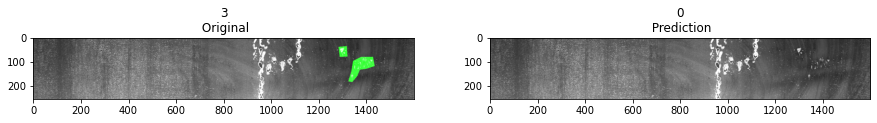

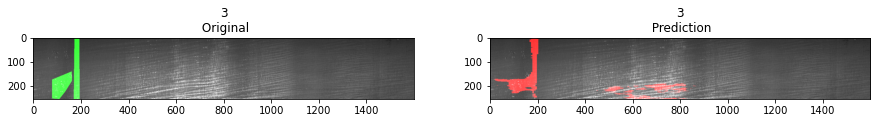

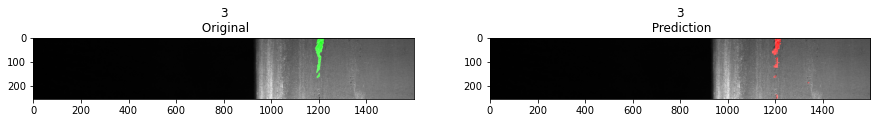

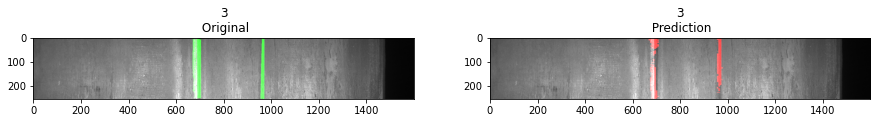

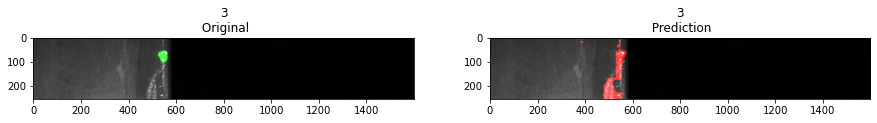

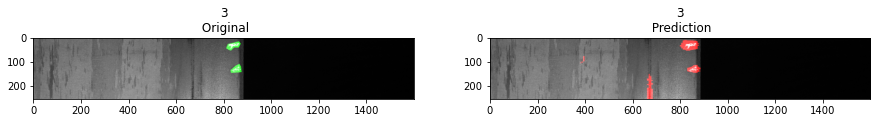

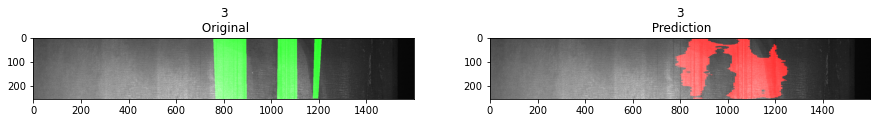

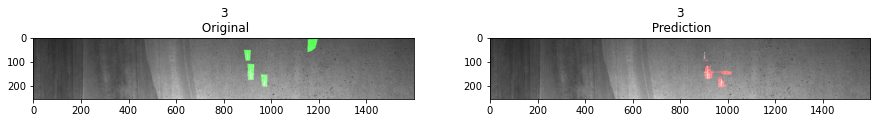

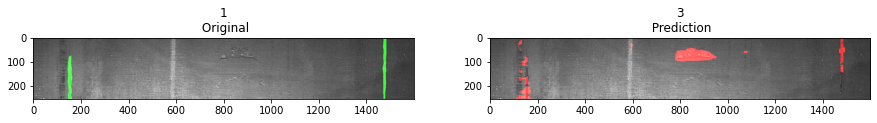

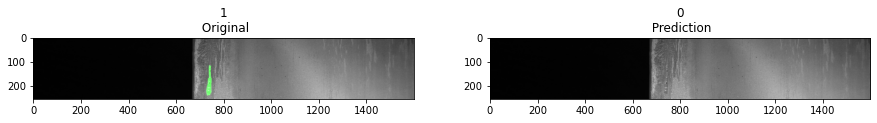

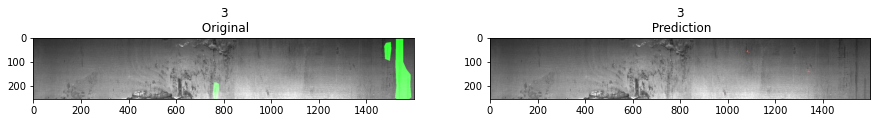

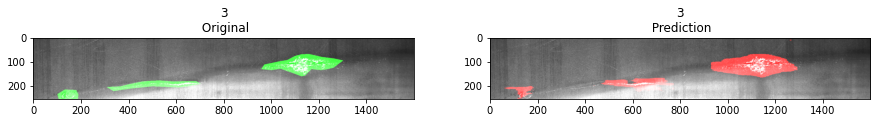

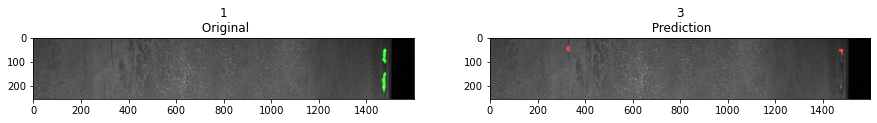

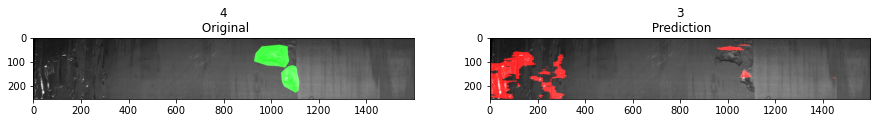

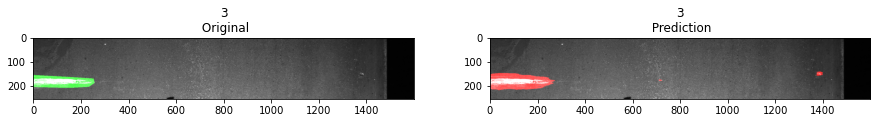

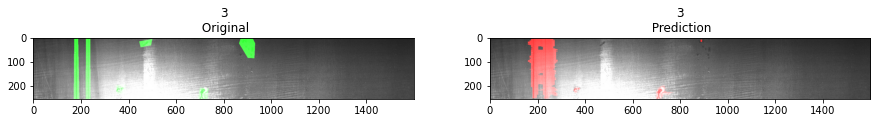

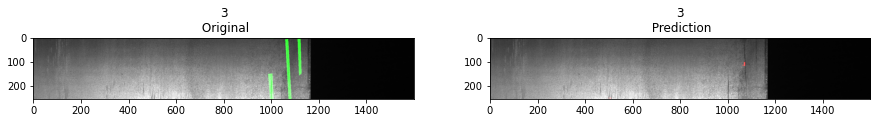

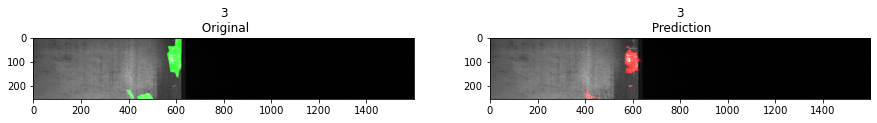

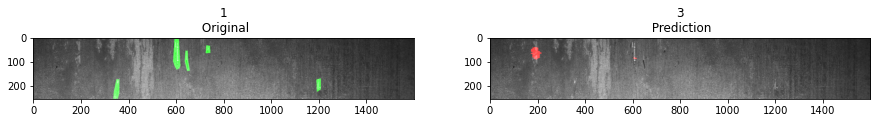

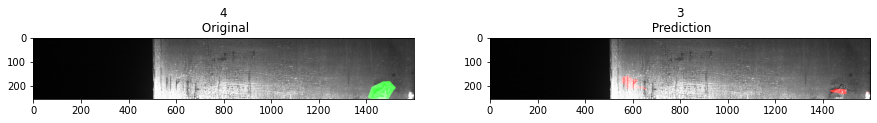

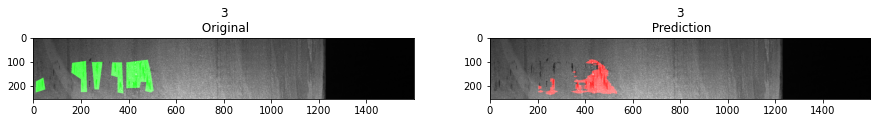

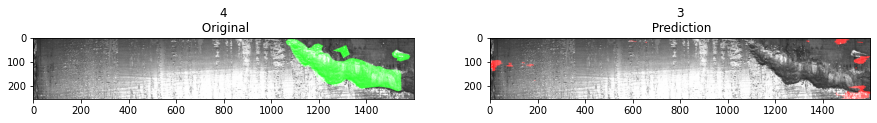

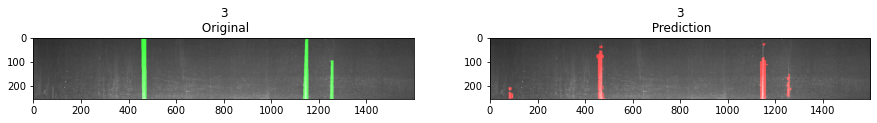

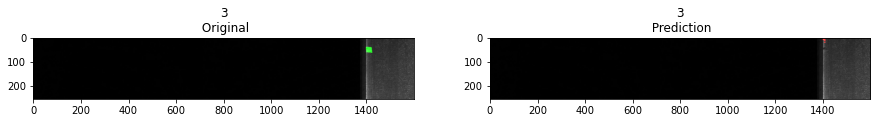

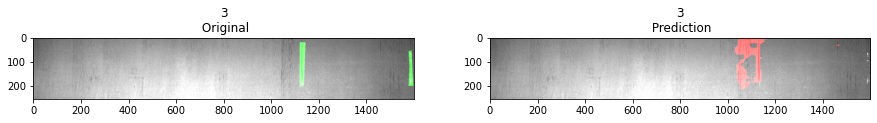

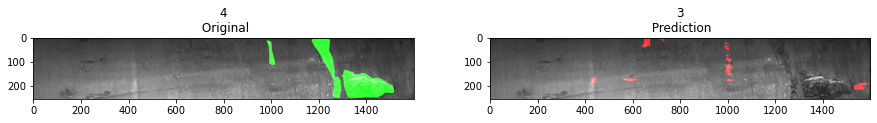

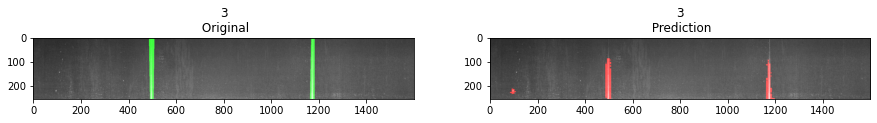

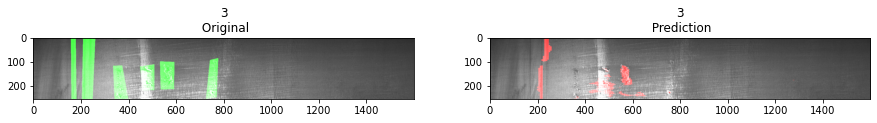

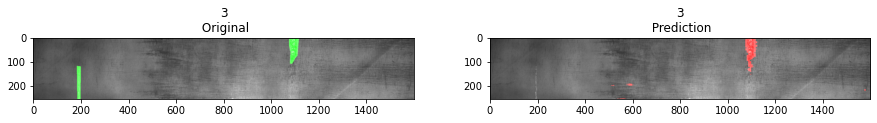

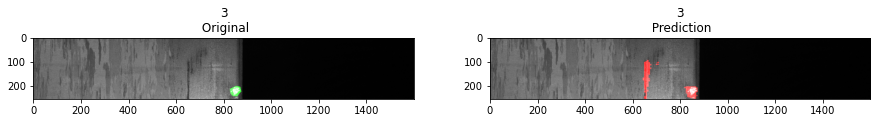

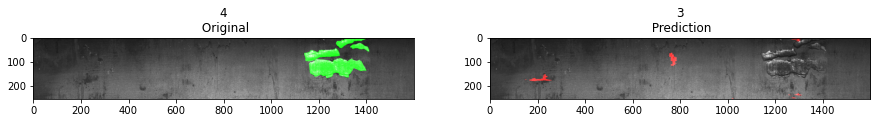

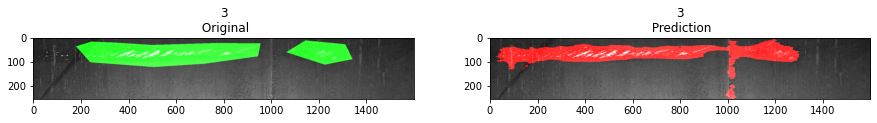

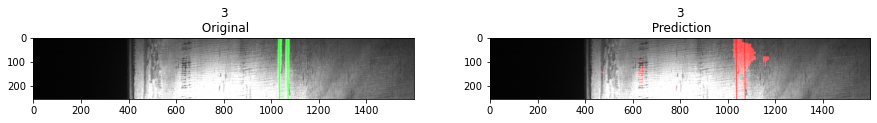

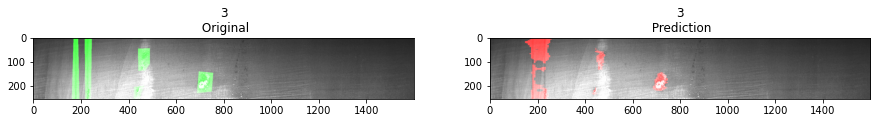

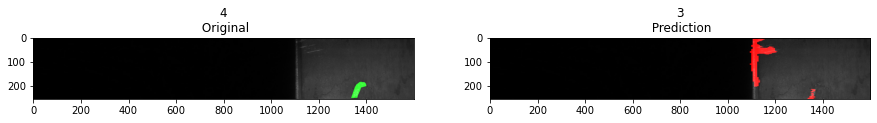

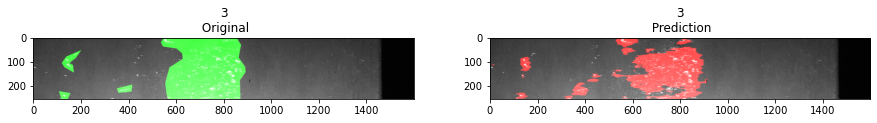

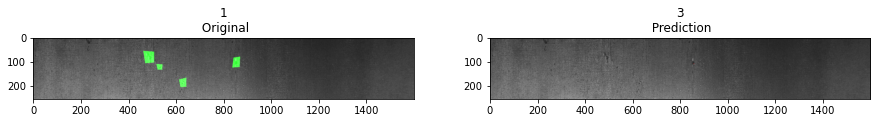

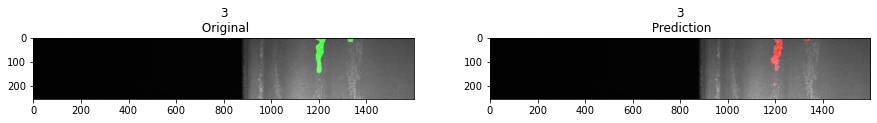

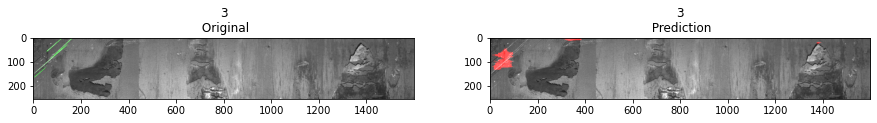

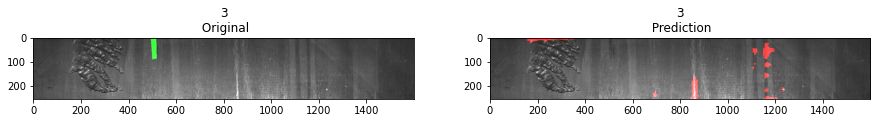

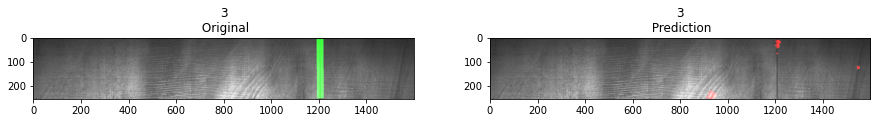

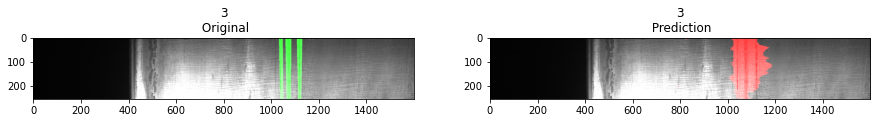

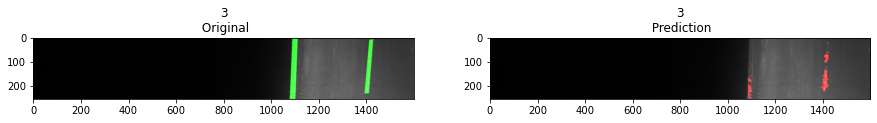

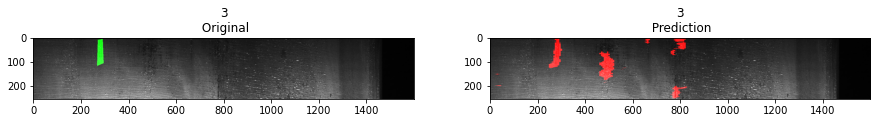

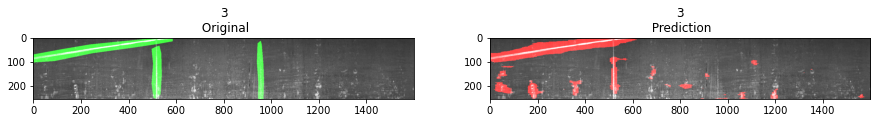

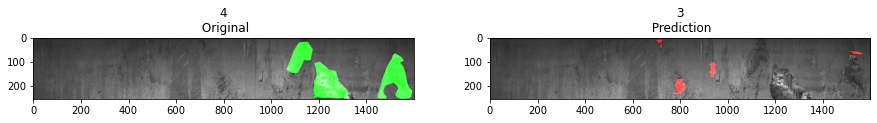

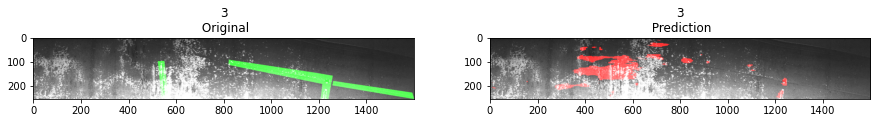

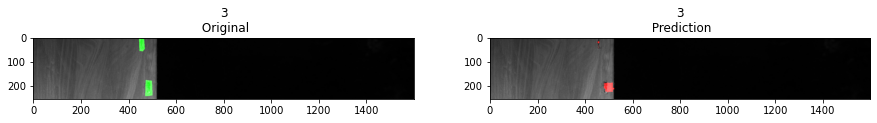

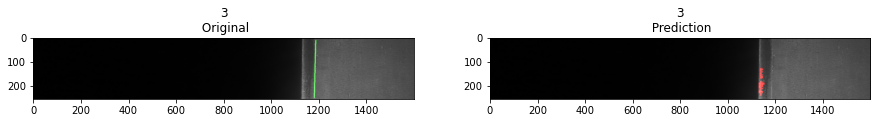

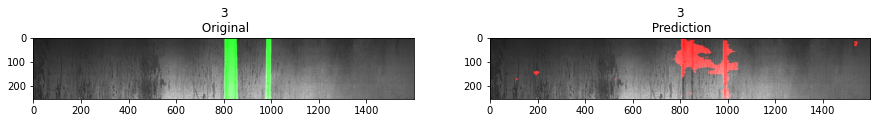

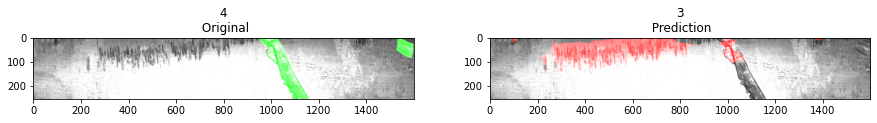

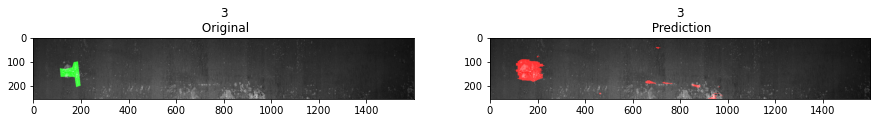

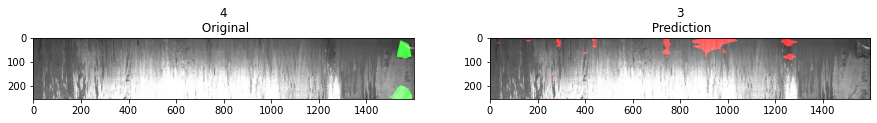

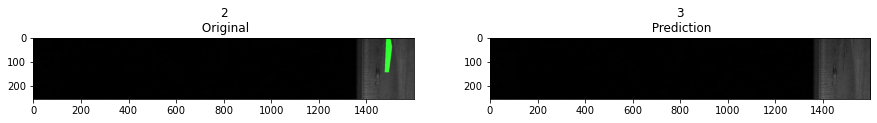

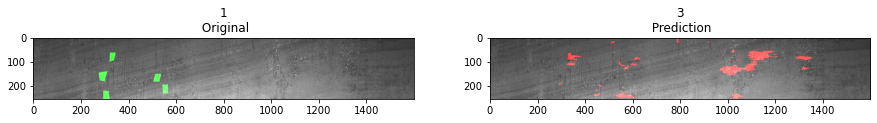

In [48]:
for i in range(100):
    plt.figure(figsize=(15, 15))
    
    #test
    img = cv2.imread(os.path.join(train_dir, test_df.ImageId[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = utilities.rle2mask(test_df.EncodedPixels[i], img.shape[0], img.shape[1])
    img[mask == 1, 1] = 255
    plt.subplot(1, 2, 1)
    plt.title(f"{test_df.ClassId[i]}\n Original")
    plt.imshow(img)
    
    #pred
    img = cv2.imread(os.path.join(train_dir, df_pred.ImageId[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = utilities.rle2mask(df_pred.EncodedPixels[i], img.shape[0], img.shape[1])
    img[mask == 1, 0] = 255
    plt.subplot(1, 2, 2)
    plt.title(f"{df_pred.ClassId[i]}\n Prediction")
    plt.imshow(img)
    
    plt.show()